In [2]:
from boxoffice.db.frames import get_movie_frame, get_box_office_day_frame
import numpy as np
import pandas as pd

frame = get_movie_frame()
bodf = get_box_office_day_frame()

if frame is None or bodf is None:
    print("Error getting data")
    exit(1)

sums = bodf.groupby("movie")["revenue"].sum()

frame["total_box_office"] = frame["id"].map(sums)

MOVIES_DB_PATH: boxoffice/db/data/data.sqlite
MOVIES_DB_PATH: ../boxoffice/db/data/data.sqlite


In [3]:
# main goal is to create a graph of how much money the highest grossing movie made each day split out by year
# so we need to get the highest grossing movie for each day
bodf['date_tmp'] = pd.to_datetime(bodf['date'])

# first we need to get the highest grossing movie for each day
highest = bodf.groupby('date_tmp').apply(lambda x: x.loc[x['revenue'].idxmax()])

# sort by date
highest = highest.sort_values('date')

# reset index
highest = highest.reset_index(drop=True)

/tmp/ipykernel_33187/1629820276.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  highest = bodf.groupby('date_tmp').apply(lambda x: x.loc[x['revenue'].idxmax()])


In [4]:
# get the year by getting the first 4 characters of the date
highest['year'] = highest['date_tmp'].dt.year

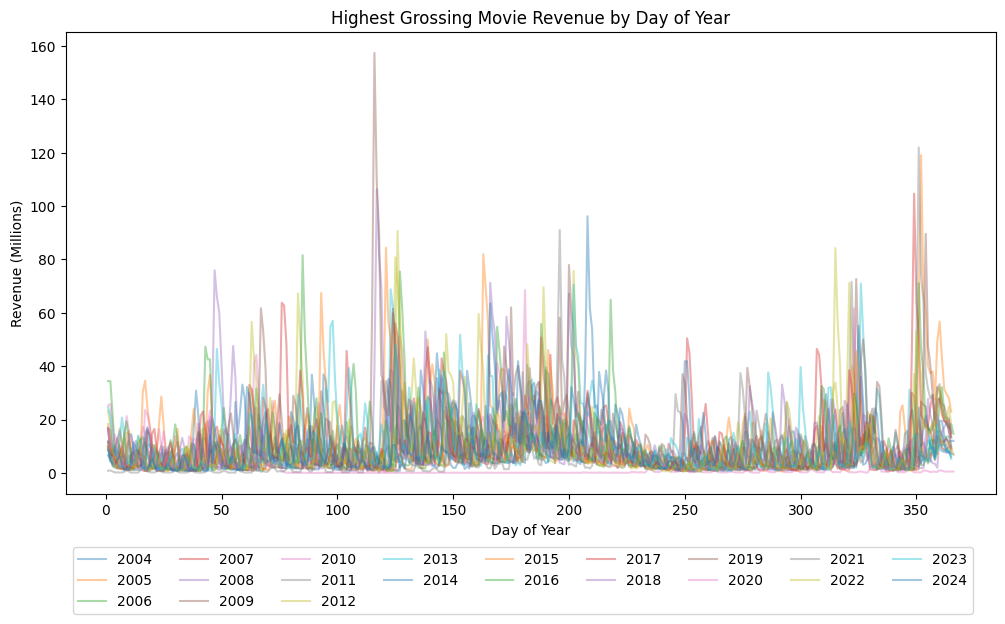

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# convert year to string
highest['day_of_year'] = highest['date_tmp'].dt.dayofyear

# loop through the years and plot the data
for year in highest['year'].unique():
    data = highest[highest['year'] == year]
    plt.plot(data['day_of_year'], data['revenue'] / 1000000, label=year, alpha=0.4)

# legend on the bottom
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=9)

# add labels and title
plt.xlabel('Day of Year')
plt.ylabel('Revenue (Millions)')
plt.title('Highest Grossing Movie Revenue by Day of Year')

# fix the y axis to not use scientific notation and be in dollars
ax.get_yaxis().get_major_formatter().set_scientific(False)


plt.show()

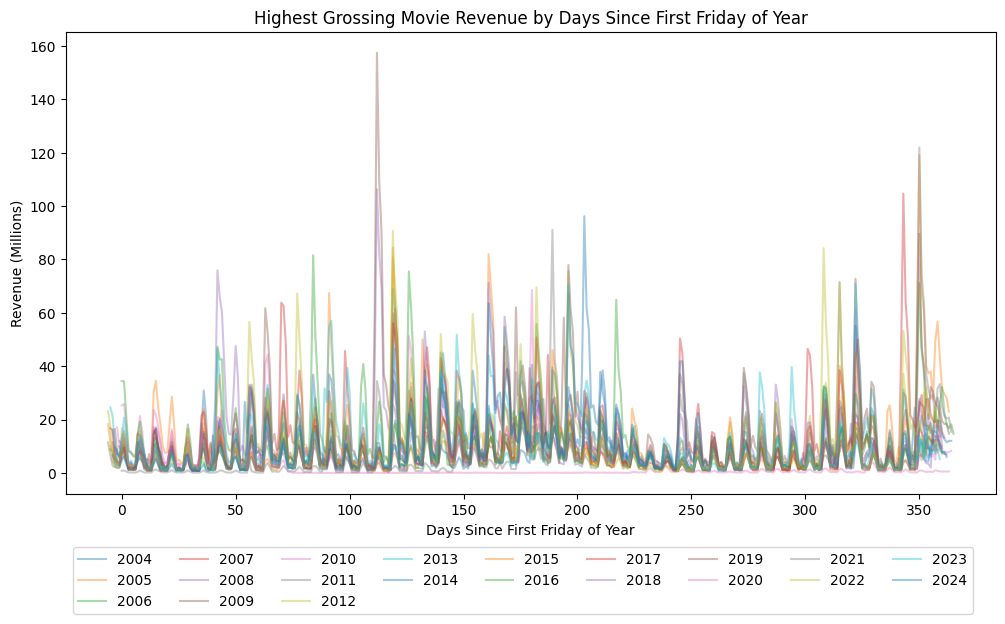

In [6]:
# now want to redo the same graph but instead of day of year, do days since first friday of the year
# get the first friday of the year
from datetime import datetime, timedelta

def get_first_friday(year):
    d = datetime(year, 1, 1)
    while d.weekday() != 4:
        d += timedelta(days=1)
    return d

highest['first_friday'] = highest['year'].apply(get_first_friday)

highest['days_since_first_friday'] = (highest['date_tmp'] - highest['first_friday']).dt.days

fig, ax = plt.subplots(figsize=(12, 6))

# loop through the years and plot the data
for year in highest['year'].unique():
    data = highest[highest['year'] == year]
    plt.plot(data['days_since_first_friday'], data['revenue'] / 1000000, label=year, alpha=0.4)

# legend on the bottom
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=9)

# add labels and title
plt.xlabel('Days Since First Friday of Year')
plt.ylabel('Revenue (Millions)')
plt.title('Highest Grossing Movie Revenue by Days Since First Friday of Year')

# fix the y axis to not use scientific notation and be in dollars
ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.show()

In [7]:
# now recreate this same plot but with sums
# first we need to get the highest grossing movie for each day
totals = bodf[['revenue', 'date_tmp']].groupby('date_tmp').sum('revenue')

# sort by date
totals = totals.sort_values('date_tmp')

# reset index
totals = totals.reset_index()

# get the year
totals['year'] = totals['date_tmp'].dt.year

# get days since first friday
totals['first_friday'] = totals['year'].apply(get_first_friday)

totals['days_since_first_friday'] = (totals['date_tmp'] - totals['first_friday']).dt.days

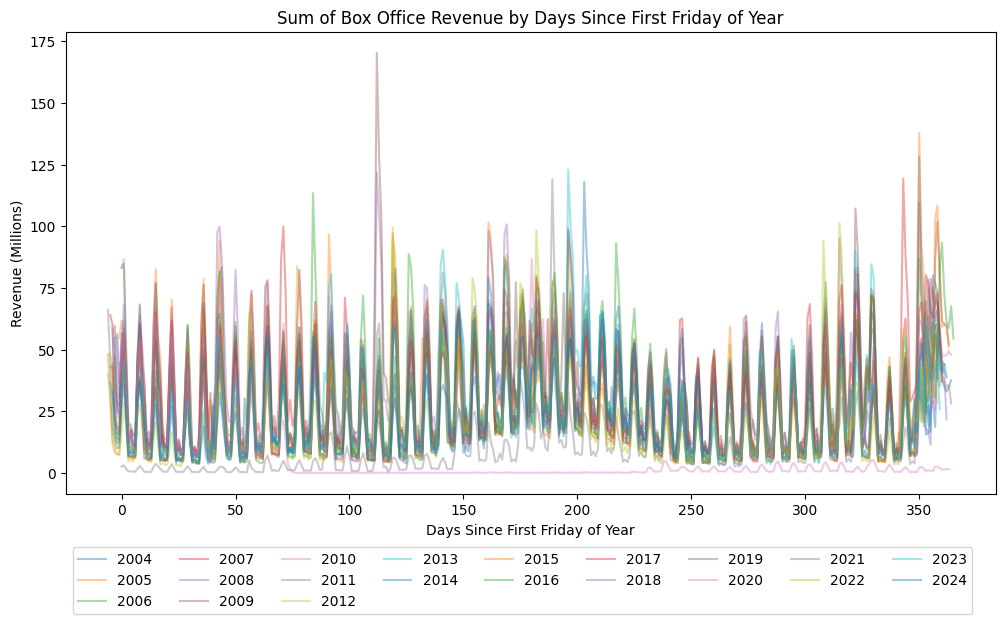

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

# loop through the years and plot the data
for year in totals['year'].unique():
    data = totals[totals['year'] == year]
    plt.plot(data['days_since_first_friday'], data['revenue'] / 1000000, label=year, alpha=0.4)

# legend on the bottom
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=9)

# add labels and title
plt.xlabel('Days Since First Friday of Year')
plt.ylabel('Revenue (Millions)')
plt.title('Sum of Box Office Revenue by Days Since First Friday of Year')

# fix the y axis to not use scientific notation and be in dollars
ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.show()

/tmp/ipykernel_33187/39550707.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=9)


Text(0.5, 1.0, 'Sum of Box Office Revenue by Days Since First Friday of Year with Median in Blue')

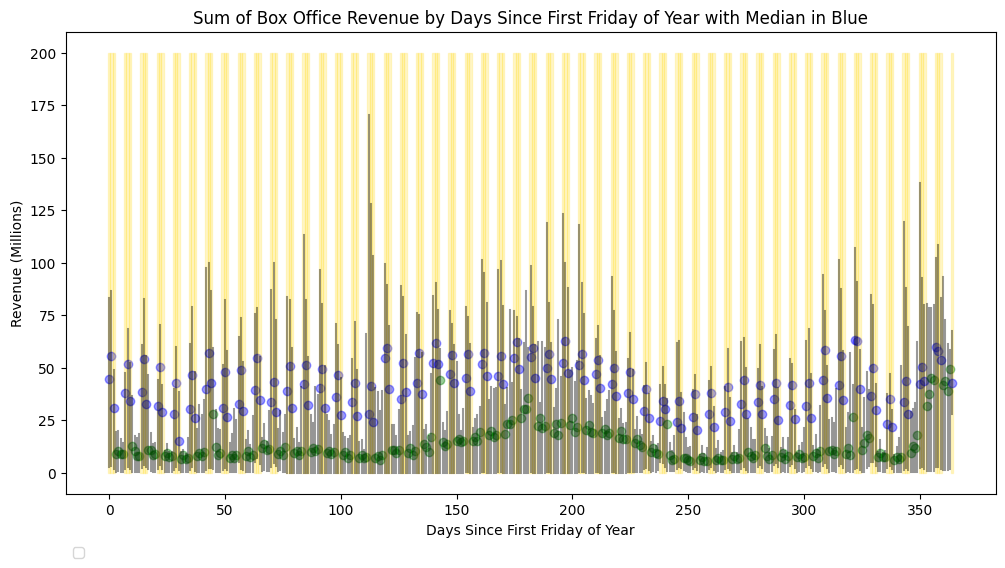

In [28]:
# instead of plotting every year just plot the lowest, highest, and median
fig, ax = plt.subplots(figsize=(12, 6))

# loop through the years and plot the data
# min_days_since_first_friday = totals['days_since_first_friday'].min()
# max_days_since_first_friday = totals['days_since_first_friday'].max()

for day in range(0, 365):
    data = totals[totals['days_since_first_friday'] == day]
    min_value = data['revenue'].min()
    max_value = data['revenue'].max()
    median_value = data['revenue'].median()

    plt.plot([day, day], [min_value / 1000000, max_value / 1000000], color='black', alpha=0.4)
    # plt.scatter(day, min_value / 1000000, color='red', alpha=0.4)
    # plt.scatter(day, max_value / 1000000, color='green', alpha=0.4)

    # do a column highlight if the day of the week is a friday or saturday
    if (day - 1) % 7 == 0 or (day + 0) % 7 == 0 or (day -2) % 7 == 0:
        plt.fill_between([day - 0.5, day + 0.5], 0, 200, color='gold', alpha=0.2)
        plt.scatter(day, median_value / 1000000, color='blue', alpha=0.4)
    else:
        plt.scatter(day, median_value / 1000000, color='green', alpha=0.4)

# legend on the bottom
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=9)

# add labels and title
plt.xlabel('Days Since First Friday of Year')
plt.ylabel('Revenue (Millions)')
plt.title('Sum of Box Office Revenue by Days Since First Friday of Year with Median in Blue')
